https://github.com/cchuang2009/2016-1/tree/master/BigData/Tbrain

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook

import seaborn as sns
%matplotlib inline

In [2]:
import random,gc
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_validate
import os,datetime

import warnings,random
warnings.filterwarnings('ignore')

/Users/macbook/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred)/y_true))/n*100
    return mape

In [4]:
#Reference  the bottom

W  = '\033[0m'  # white (normal)
R  = '\033[31m' # red
G  = '\033[32m' # green
O  = '\033[1;33m' # orange
B  = '\033[34m' # blue
P  = '\033[35m' # purple

T =  '\033[1;33;47m' #Title

In [5]:
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')

features=train_df.columns[2:]

NaN_ratio
---

In [6]:
def nan_ratio(df):
    for i in range(len(df.columns)):
        ratio=1-df[df.columns[i]].describe().T['count']/len(df)
        if ratio!=0:
           print("Features ",R, df.columns[i], B,"nan ratio ",W,ratio) 
    

In [7]:
sns.set_style("whitegrid")
def nan_plot(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    missing.plot.bar()

In [8]:
nan_ratio(train_df)

Features   parking_area  nan ratio   0.9482833333333334
Features   parking_price  nan ratio   0.7677499999999999
Features   txn_floor  nan ratio   0.26503333333333334
Features   village_income_median  nan ratio   0.019033333333333347


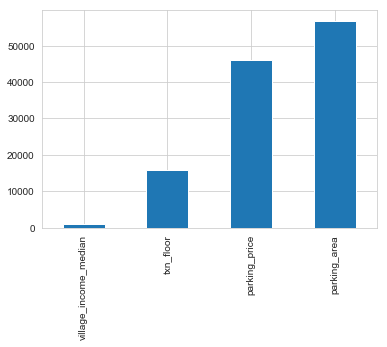

In [9]:
nan_plot(train_df)

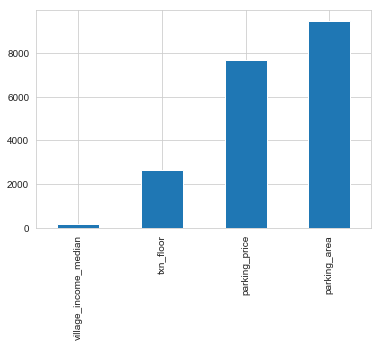

In [10]:
nan_plot(test_df)


 mu = 12937270.81 and sigma = 55224170.14



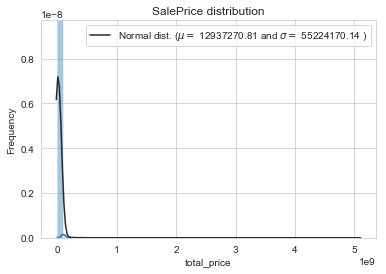

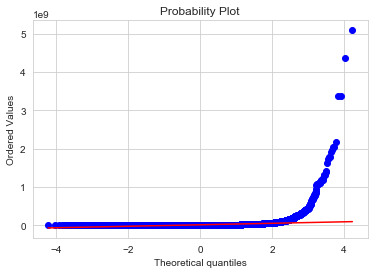

In [14]:
import scipy
import scipy.stats as stats
from scipy.stats import norm, skew 
sns.distplot(train_df['total_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['total_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['total_price'], plot=plt)

From last picture, the skewness with respect to total_price is too large to work with; we had better to trnasform data for better fitting, for instance: log1p(x)= log(1+x).


 mu = 15.52 and sigma = 1.17



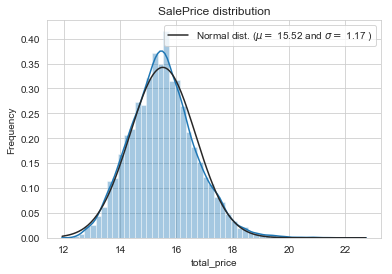

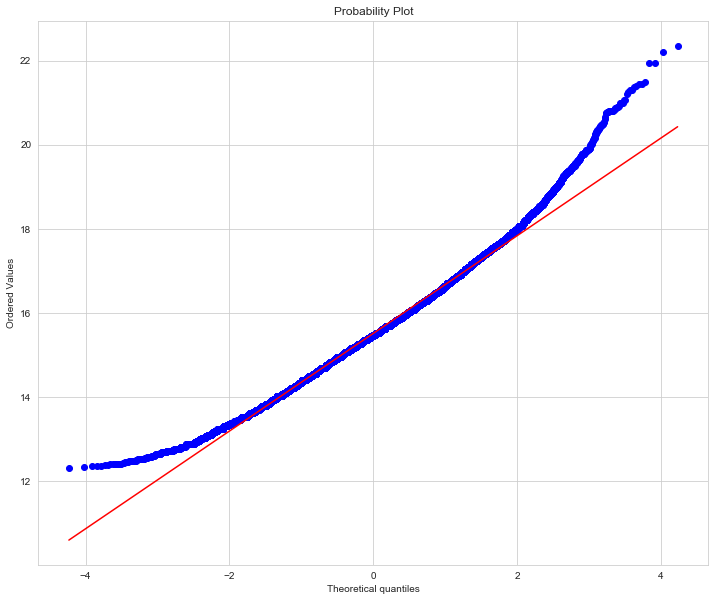

In [15]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_df["total_price"] = np.log1p(train_df["total_price"])

#Check the new distribution 
sns.distplot(train_df['total_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['total_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure(figsize=[12,10])
res = stats.probplot(train_df['total_price'], plot=plt)


EDA-1
---
Fill nan

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121e31dd8>,
      dtype=object)

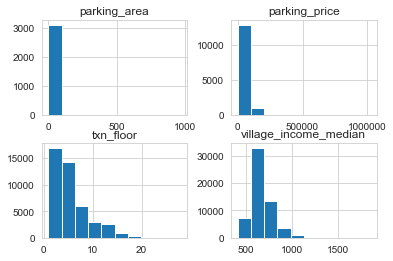

In [16]:
nan_features=['parking_area','parking_price','txn_floor','village_income_median']
train_df[nan_features].hist()

In [17]:
def fillnan(df_1,df_2,features):
    df_1[features[0]].fillna(value=0,inplace=True)
    df_2[features[0]].fillna(value=0,inplace=True)
    df_1[features[1]].fillna(value=0,inplace=True)
    df_2[features[1]].fillna(value=0,inplace=True)
    
    df=pd.concat([df_1[features],df_2[features]],axis=0)
    for f in features[2:]:
        df_1[f].fillna(value=df[f].median(),inplace=True)
        df_2[f].fillna(value=df[f].median(),inplace=True)
    return df_1,df_2

In [18]:
train_df,test_df=fillnan(train_df,test_df,nan_features)

In [19]:
nan_ratio(train_df)

Models
---

In [20]:
y = train_df['total_price']
X=train_df.iloc[:len(y), 1:-1]

In [21]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb


In [22]:
#Validation function
n_folds = 5

def rmsle_cv(model,X,y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

L1 regularization
absolute value of magnitude

In [90]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 2.578346975, random_state=0))
score = (rmsle_cv(lasso, X,y))
print("\nLasso score: {:.10f} ({:.8f})\n".format(score.mean(), score.std()))


Lasso score: 0.9999999999 (0.00967100)



total reset

2.578347
1.00000000 (0.00967100)

# 2.578346975
# 0.9999999999 (0.00967100)

2.57834697
0.9999999997 (0.00967100)

2.578346969
0.9999999997 (0.00967100)

2.57834696
0.9999999994 (0.00967100)

2.578346955
0.9999999992 (0.00967100)

2.57834695
0.9999999991 (0.00967100)

2.5783469
0.9999999974 (0.00967100)

2.5783466
0.9999999872 (0.00967100)

2.5783463
0.9999999771 (0.00967100)

2.578346
0.99999997 (0.00967100)

2.578345
0.99999993 (0.00967100)

2.57834
0.99999976 (0.00967099)

2.5783
0.99999841 (0.00967095)

alpha = 2.578, random_state=0
score = 0.99998827 (0.00967063)

alpha = 2.577, random_state=0
score = 0.99995446 (0.00966955)

alpha = 2.576, random_state=0
score = 0.99992067 (0.00966848)

alpha = 2.575, random_state=0
score = 0.9999 (0.0097)

alpha = 2.57, random_state=0
score = 0.9997 (0.0097)

alpha = 2.56, random_state=0
score = 0.9994 (0.0097)

alpha = 2.559, random_state=0
score = 0.9993 (0.0097)

alpha = 2.55, random_state=0
score = 0.9990 (0.0096)

alpha = 2.5, random_state=0
score = 0.9974 (0.0096)

alpha = 2, random_state=0
score = 0.9825 (0.0091)

alpha = 1.7, random_state=0
score = 0.9750 (0.0087)

alpha = 1.6, random_state=0
score = 0.9728 (0.0086)

test10
alpha = 1.5, random_state=1
score = 0.9707 (0.0085)

test19
alpha = 1.5, random_state=2
score = 0.9707 (0.0085)

test20
alpha = 1.5, random_state=3
score = 0.9707 (0.0085)

alpha = 1.5, random_state=0
score = 0.9707 (0.0085)

test11
alpha = 1.2, random_state=1
score = 0.9652 (0.0082)

test12
alpha = 1.1, random_state=1
score = 0.9604 (0.0088)

test13
alpha = 1.05, random_state=1
score = 0.9563 (0.0081)

test14
alpha = 1.07, random_state=1
score = 0.9579 (0.0084)

test15
alpha = 0.000005, random_state=1
score = 0.7009 (0.0238)

test16
alpha = 0.000009, random_state=1
score = 0.7009 (0.0238)

test17
alpha = 0.0001, random_state=1
score = 0.7010 (0.0237)

test18
alpha = 0.001, random_state=1
score = 0.7024 (0.0235)


default
alpha = 0.0005, random_state = 1
score = 0.7017 (0.0235)

test1
alpha = 0.00055, random_state = 1
score = 0.7018 (0.0235)

test2
alpha = 0.0002, random_state=1
score = 0.7012 (0.0236)

test3
alpha = 0.0006, random_state=1
score = 0.7019 (0.0235)

test4
alpha = 0.002, random_state=1
score = 0.7047 (0.0237)

test5
alpha = 0.1, random_state=1
score = 0.8261 (0.0213)

test6
alpha = 0.2, random_state=1
score = 0.8720 (0.0183)

test7
alpha = 1, random_state=1
score = 0.9524 (0.0076)

test21
alpha = 1, random_state=0
score = 0.9524 (0.0076)

test8
alpha = 10, random_state=1
score = 1.0656 (0.0101)

test9
alpha = 5, random_state=1
score = 1.0656 (0.0101)